# Data Oriented Programming Paradigm: Assignment 3
## What factors influence the primary school graduation rate?

**Group 41:**
- András Bonifác Kónya (ID:01502933)
- Branimir Raguž (ID:12123474)
- Paul Georg Direktor (ID:12117574)
- Thummanoon Kunanuntakij (ID:12122522)

## Report Outline

1. Introduction
2. Questions that we plan to answer in this report
3. Overview of our approach
4. Data Source Used
5. Data Science Library Used
6. Primary School Completion Rate (Target Variable)
7. Health Data
8. Economic Data
9. Government Spending Data
10. Prediction Model
11. Summary & Discussion
12. Team Management

## 1. Introduction

Our report focuses on finding the influencing variables that could explain the primary school graduation rate of each countries. We explore relations of the rate with 3 different dataset; country's income, government spending on education and general health statistics. By using exploratory data analysis on each dataset, we try to explain influence of each variables on the graduation rate. Then, we identify potential variable that might be able to predict the rate in the future. Finally, we put together these variables in a machine learning model to predict the rate in the recent year.

## 2. Questions that we plan to answer in this report

1. What is the primary school graduation rate of each country?
2. Does a country's income, spending on education, or general health level influence the rate?
3. How well can we predict the primary school graduation rate of a country in the future?

## 3. Overview of our approach

- Use data from 2010 to 2017 as study data.
- Use 2018-2019 as unseen data.
- Perform exploratory data analysis for each of the following dataset
    - Base Data
    - Health Data
    - Economic Data
    - Government Spending Data.
- For each dataset, we clean the data by remove/impute missing value.
- Using data visualisation and other data exploration tools to discover relationship between variables in each data with our target variable, primary school completion rate.
- From the analysis, we select a list of variables that influence the target variables.
- At the end, we gather all of the variables and train a linear model using the variables to predict the completion rate.
- We use our model to predict primary school completion rate in 2018-2019.

## 4. Data Source Used
1. World Bank (https://datacatalog.worldbank.org/search/dataset/0037712)
- For education statistics specifically primary school graduation rate, general information about each countries, economics and government spending data.

2. Penn World Table (https://www.rug.nl/ggdc/productivity/pwt/)
- For economics data.

3. Our World In Data: Global Health (https://ourworldindata.org/health-meta#child-mortality)
- For health statistics

## 5. Data Science Library Used

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
sns.set(style='white', rc={'figure.figsize':(12,8)})

## 6. Primary School Completion Rate (Target Variable)
### 6.1 Data Definition and Initial Gathering

We get the taget variable from [the World Bank Open Data](https://datacatalog.worldbank.org/search/dataset/0037712).

- **completion_rate** (Primary completion rate, total (% of relevant age group))
      
    - Definition: *Primary completion rate, or gross intake ratio to the last grade of primary education, is the number of new entrants (enrollments minus repeaters) in the last grade of primary education, regardless of age, divided by the population at the entrance age for the last grade of primary education. Data limitations preclude adjusting for students who drop out during the final year of primary education.*

Because the original data retrieved from the World Bank contain a lot of data that is either irrelavant or unimportant for our report. We use the following code to filter only the data that we used and we will use the result file "world_bank.csv" insteadd of the original file in this report.

```python
raw_data_df = pd.read_csv('./data/world_bank/WDIData.csv')
raw_data_df_2 = raw_data_df[raw_data_df['Indicator Name'].isin([
    'Primary completion rate, total (% of relevant age group)',
])].drop(columns=['Country Name', 'Indicator Code'] + list(map(lambda s: str(s), range(1960, 2010)))) 
raw_data_df_3 = raw_data_df_2.drop(columns=raw_data_df_2.columns[-1])
raw_data_df_3.to_csv('./data/world_bank/WDIData_lite.csv', index=False)
data_df_1 = pd.read_csv('./data/world_bank/WDIData_lite.csv')
year_columns = data_df_1.columns[2:]
data_df_2 = data_df_1.melt(
    id_vars=['Country Code', 'Indicator Name'], value_vars=year_columns
)
data_df_3 = data_df_2.pivot(
    index=['Country Code', 'variable'],
    columns=['Indicator Name'],
    values=['value']
)
data_df_3.columns = data_df_3.columns.droplevel()
data_df_4 = data_df_3.rename(
    columns={
        'Primary completion rate, total (% of relevant age group)': 'completion_rate'
    }
)
data_df_4.index.names = ['country', 'year']
data_df_4.to_csv('./data/world_bank.csv')
```

### 6.2 Loading the data

In [2]:
base_data_df = pd.read_csv('./data/world_bank.csv')
base_data_df = base_data_df[['country', 'year',
                             'completion_rate'
                            ]]
country_df = pd.read_csv('./data/country_info.csv')[['Country Code', 'Region', 'Income Group']]
country_df = country_df.rename(columns={'Country Code': 'country'})
data_df = pd.merge(base_data_df, country_df, on="country")
data_df.sample(n=5, random_state=100)

,country,year,completion_rate,Region,Income Group
310,AUT,2016,99.656723,Europe & Central Asia,High income
4830,TEC,2000,94.281479,NaN,NaN
1423,EGY,2016,96.906448,Middle East & North Africa,Lower middle income
1227,DNK,2009,97.973022,Europe & Central Asia,High income
4313,SDN,2008,NaN,Sub-Saharan Africa,Low income


In [3]:
test_data_df = data_df[data_df['year'] >= 2018]
data_df = data_df[data_df['year'] < 2018]

### 6.3 Data Cleaning

We could see from the table of example countries and the bar plot (Figure 6.2.1) that there are a lot of missing value in the data and there is no common year which the data are all available.

In [4]:
completion_rate_pivot = data_df.pivot(index='country', columns=['year'], values=['completion_rate'])
completion_rate_pivot.loc[['USA', 'JPN', 'AUT', 'DEU', 'IND', 'THA']].transpose()

country                     USA  JPN         AUT         DEU        IND  \
                year                                                      
completion_rate 2000        NaN  NaN         NaN  104.346916  71.486107   
                2001        NaN  NaN         NaN  105.795708  72.169540   
                2002        NaN  NaN  100.222198  101.670143  75.560066   
                2003        NaN  NaN         NaN  100.681236  80.044380   
                2004        NaN  NaN   98.744301   99.470268        NaN   
                2005        NaN  NaN         NaN   96.879639        NaN   
                2006        NaN  NaN         NaN   98.496803        NaN   
                2007        NaN  NaN         NaN  103.536980        NaN   
                2008        NaN  NaN         NaN  101.979027  94.757584   
                2009        NaN  NaN         NaN  102.383797  95.746292   
                2010        NaN  NaN         NaN  102.015350        NaN   
                2011        NaN  NaN   96.772018  101.566879  92.763359   
                2012        NaN  NaN   96.693718   98.653137        NaN   
                2013        NaN  NaN   97.606010   98.398689  96.200890   
                2014        NaN  NaN   98.691849   97.282707  97.571121   
                2015        NaN  NaN  100.373787   98.918297  97.711319   
                2016        NaN  NaN   99.656723   97.937202  96.230698   
                2017  98.832199  NaN   99.453178   98.805138  94.373749   

country                     THA  
                year             
completion_rate 2000  84.892181  
                2001  86.880768  
                2002        NaN  
                2003        NaN  
                2004        NaN  
                2005        NaN  
                2006        NaN  
                2007        NaN  
                2008        NaN  
                2009        NaN  
                2010        NaN  
                2011        NaN  
                2012        NaN  
                2013        NaN  
                2014        NaN  
                2015        NaN  
                2016        NaN  
                2017  93.452553

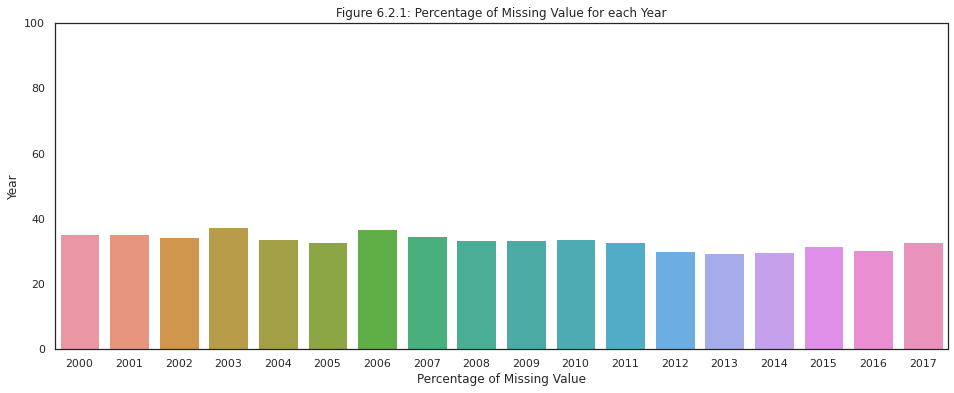

In [5]:
na_completion_rate = data_df.groupby('year').apply(lambda df: df.isna().mean())[['completion_rate']]
na_completion_rate = na_completion_rate.rename(columns={'completion_rate': 'missing_completion_rate'})
plt.figure(figsize=(16, 6))
g = sns.barplot(x=na_completion_rate.index, y=na_completion_rate['missing_completion_rate'] * 100)
txt = g.set(title="Figure 6.2.1: Percentage of Missing Value for each Year",
            xlabel="Percentage of Missing Value",
            ylabel = "Year",
            ylim=[0, 100])

Because of these, we will progress by treating each country and year as individual obeservation and drop all of the N/A.

In [6]:
data_df = data_df.dropna()
data_df = data_df.set_index(['country', 'year'])

### 6.4 Data Exploration

#### Target Variable Distribution

From, We could see the distribuition of the data have approximately the same structure. We have the mode at around 100% completion rate. Also there is a small peak at around 65%. What is interesting is that the standard diviation amd the range of the rate is quite high, ranging from 16 to 134.

In [7]:
data_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
completion_rate,2339.0,88.380652,19.453671,16.57523,81.018227,95.513023,100.242798,134.542511


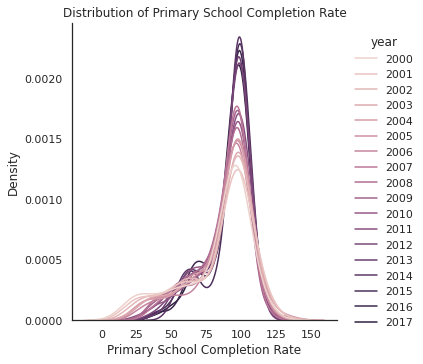

In [8]:
g = sns.displot(data_df, x="completion_rate", hue="year", kind="kde")
txt = g.set(title="Distribution of Primary School Completion Rate", xlabel="Primary School Completion Rate")

From the base data, we could see that different country group has distinct level of the completion rate. Low income countries are the lowest and the high income group has the highest.

### 6.5 Summary & Important Variables

In this section, the list of variables that is important are
1. `Country` & `Year` are the index of our dataframe.
2. `completion_rate` is our target variable.
3. `Income Group` is the level of income of a country. We could see from the plot that it clearly influence the data. The higher the income, the higher the rate is.

## 7. Health Data

### 7.1 Data Definition and Initial Gathering

The data is from [Life expectancy at birth](https://www.cia.gov/the-world-factbook/field/life-expectancy-at-birth/country-comparison) and [The world in data](https://ourworldindata.org/health-meta#child-mortality)

- **Life expectancy** (Primary completion rate, total (% of relevant age group))
      
    - Definition: *Primary completion rate, or gross intake ratio to the last grade of primary education, is the number of new entrants (enrollments minus repeaters) in the last grade of primary education, regardless of age, divided by the population at the entrance age for the last grade of primary education. Data limitations preclude adjusting for students who drop out during the final year of primary education.*
    
- **Deaths(HIV/AIDS)**
    - Definition: *Death from HIV/AIDs*
- **Incidence(HIV/AIDS)**
    - Definition: *Number of new HIV/AIDs patient*
- **Prevalence(HIV/AIDS)**
    - Definition: *Number of total HIV/AIDs patient*
- **Disability-Adjusted Life Years**
    - Definition: *The disability-adjusted life year is a measure of overall disease burden, expressed as the number of years lost due to ill-health, disability or early death.*
- **Maternal mortality**
    - Definition: *Maternal mortality refers to deaths due to complications from pregnancy or childbirth.*
- **Child mortality**
    - Definition: *Child mortality rate is the share of newborns who die before reaching the age of 5.*

### 7.2 Loading the data

In [9]:
health_df = pd.read_csv(r'./data/HealthData.csv')
health_df = health_df.drop(columns=[health_df.columns[0]])
health_df.sample(n=5, random_state=100).transpose()

,920,1185,1428,1432,801
Country,DEU,ITA,MDV,MLI,FJI
Year,2014,2009,2008,2003,1992
Life expectancy,80.642,81.783,75.073,50.373,65.278
Children out of primary school,92141,13750,177,925765,3786
Deaths(HIV/AIDS),502.850039,890.876487,0.429475,6580.810966,4.273043
Incidence(HIV/AIDS),6338.271083,5431.237623,1.034206,10337.653587,19.011384
Prevalence(HIV/AIDS),10519.532792,17278.983372,0.962997,9368.349747,8.711671
Disability-Adjusted Life Years,19336.961056,18474.001003,22871.797464,78632.270425,41346.047573
Maternal mortality,6.0,4.0,96.0,754.0,59.0
Child mortality,0.39,0.41,1.6,19.2,2.64


### 7.3 Data Cleaning

In [10]:
health_df = health_df[(health_df['Year'] >= 2010)]

### 7.4 Data Exploration

#### 7.4.1 Data Exploration on the Health Dataset

Text(0.5, 1.0, 'Disability-Adjusted Life Years in 2017')

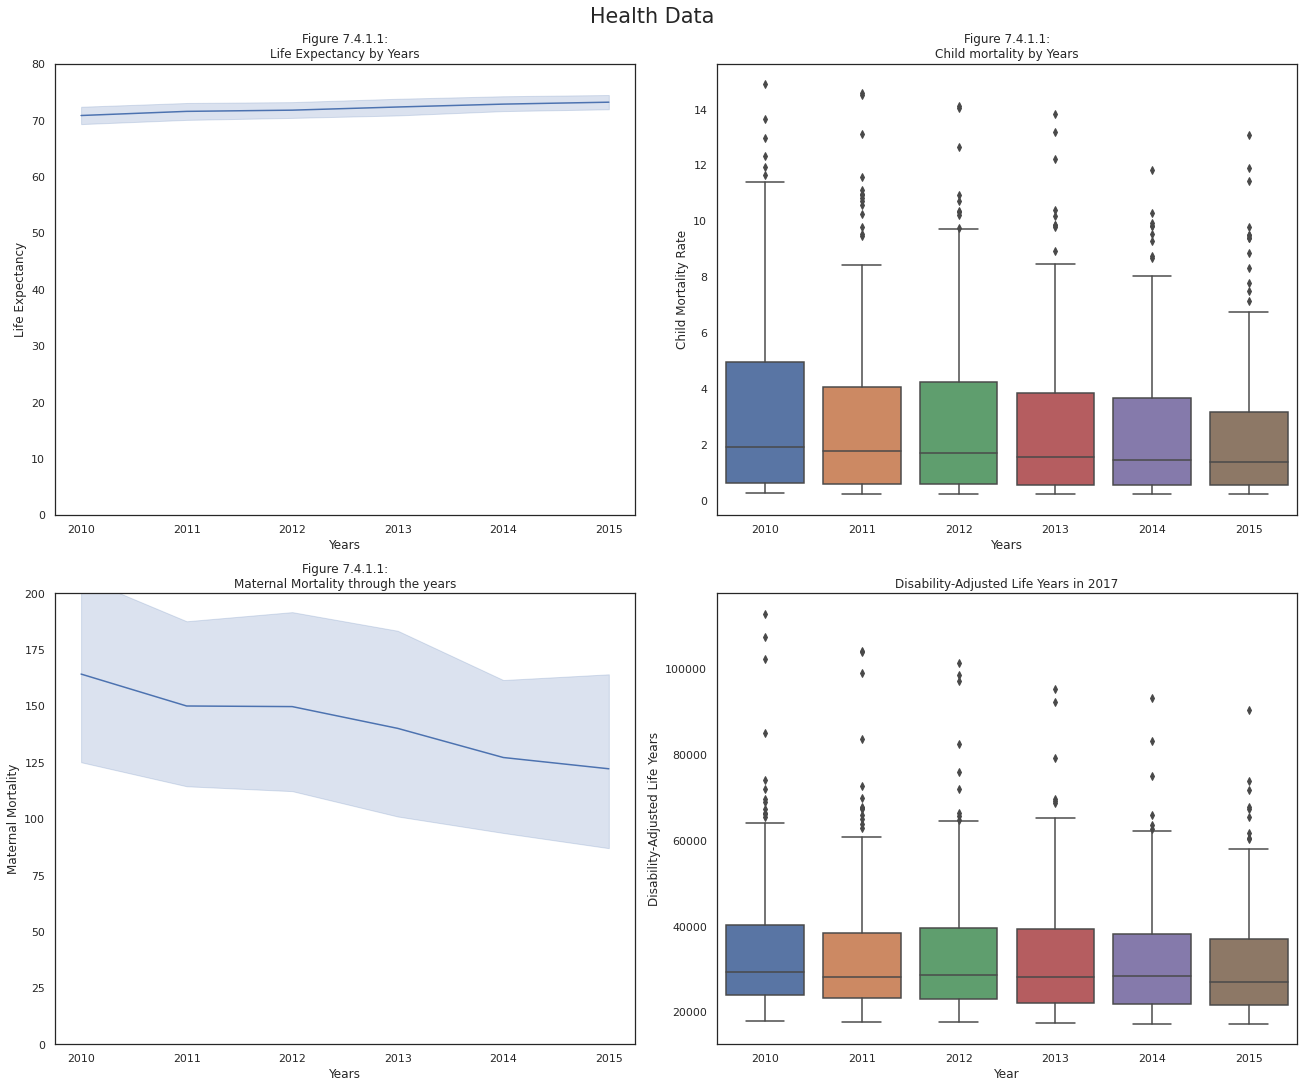

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(18, 15), constrained_layout=True)

fig.suptitle('Health Data', fontsize='xx-large')

sns.lineplot(ax=axes[0, 0], data=health_df, x='Year', y='Life expectancy')
axes[0, 0].set(title='Figure 7.4.1.1:\nLife Expectancy by Years', ylabel='Life Expectancy',
    xlabel='Years', ylim=[0, 80])

sns.boxplot(ax=axes[0, 1], data=health_df, x='Year', y='Child mortality')
axes[0, 1].set(title='Figure 7.4.1.1:\nChild mortality by Years', ylabel='Child Mortality Rate',
    xlabel='Years')

sns.lineplot(ax=axes[1, 0], data=health_df, x='Year', y='Maternal mortality')
axes[1, 0].set(title='Figure 7.4.1.1:\nMaternal Mortality through the years', ylabel="Maternal Mortality",
    xlabel='Years', ylim=[0, 200])

sns.boxplot(
    ax=axes[1, 1],
    data=health_df,
    y='Disability-Adjusted Life Years',
    x='Year'
).set_title('Disability-Adjusted Life Years in 2017')


#### 7.4.2 Data Exploration on the relationship between health data and the primary school completion rate

In [12]:
merged_heath_df = health_df.rename(
    columns={'Country': 'country', 'Year': 'year'}
).set_index(['country', 'year']).merge(data_df, right_index=True, left_index=True)

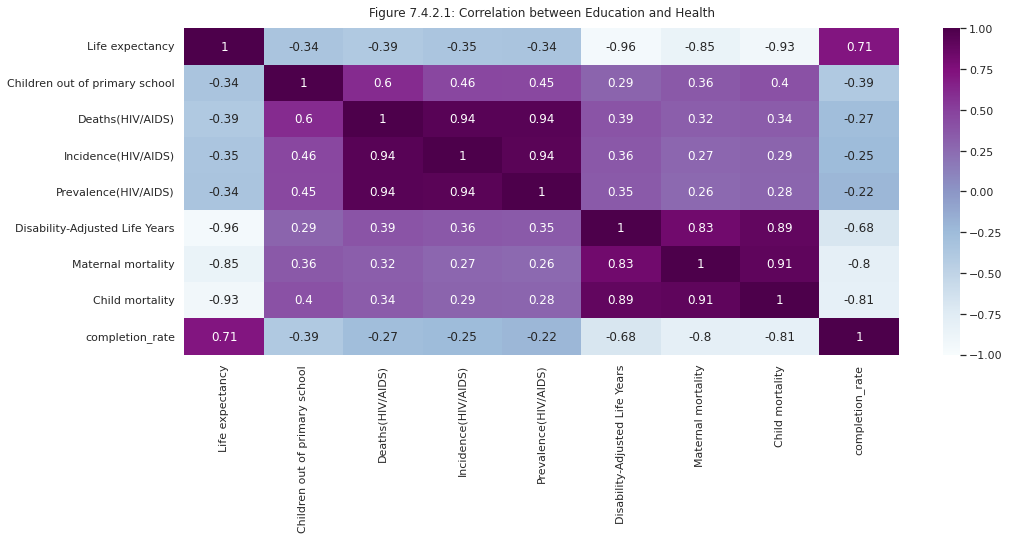

In [13]:
plt.figure(figsize=(16,6))
heatmap = sns.heatmap(merged_heath_df.corr(), vmin=-1, vmax=1, annot=True, cmap="BuPu")
heatmap.set_title('Figure 7.4.2.1: Correlation between Education and Health', fontdict={'fontsize':12}, pad = 12);

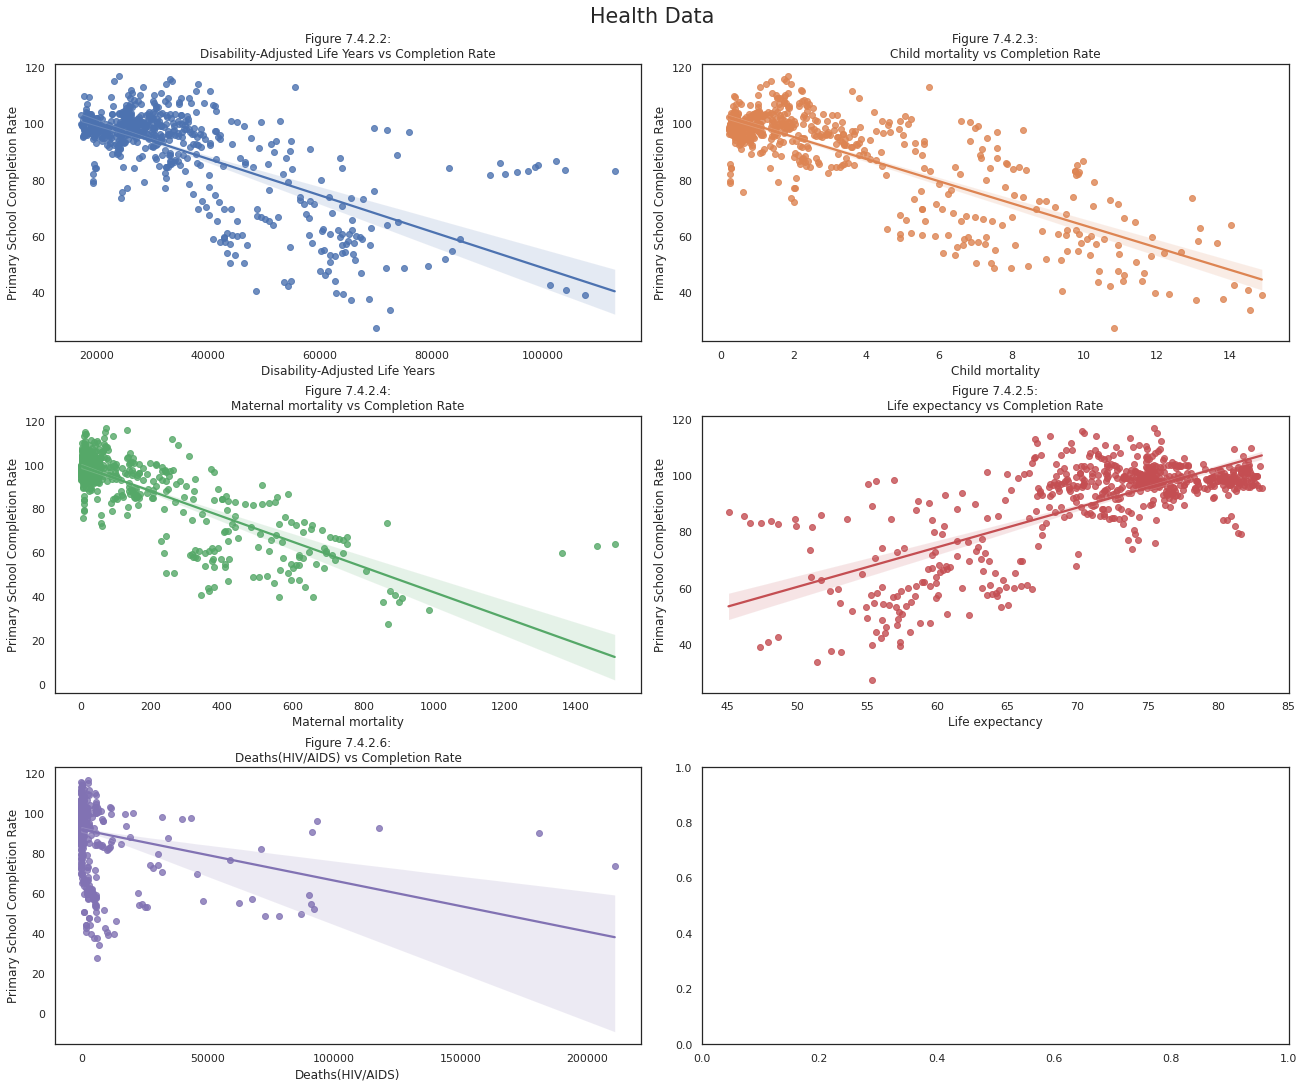

In [14]:
fig, axes = plt.subplots(3, 2, figsize=(18, 15), constrained_layout=True)

fig.suptitle('Health Data', fontsize='xx-large')

sns.regplot(
    ax=axes[0, 0], data=merged_heath_df, y='completion_rate', x='Disability-Adjusted Life Years',
    color=sns.color_palette()[0]
)
axes[0, 0].set(title='Figure 7.4.2.2:\nDisability-Adjusted Life Years vs Completion Rate',
               ylabel='Primary School Completion Rate',
               xlabel='Disability-Adjusted Life Years')

sns.regplot(
    ax=axes[0, 1], data=merged_heath_df, y='completion_rate', x='Child mortality',
    color=sns.color_palette()[1]
)
axes[0, 1].set(title='Figure 7.4.2.3:\nChild mortality vs Completion Rate',
               ylabel='Primary School Completion Rate',
               xlabel='Child mortality')


sns.regplot(
    ax=axes[1, 0], data=merged_heath_df, y='completion_rate', x='Maternal mortality',
    color=sns.color_palette()[2]
)
axes[1, 0].set(title='Figure 7.4.2.4:\nMaternal mortality vs Completion Rate',
               ylabel='Primary School Completion Rate',
               xlabel='Maternal mortality')


sns.regplot(
    ax=axes[1, 1], data=merged_heath_df, y='completion_rate', x='Life expectancy',
    color=sns.color_palette()[3]
)
axes[1, 1].set(title='Figure 7.4.2.5:\nLife expectancy vs Completion Rate',
               ylabel='Primary School Completion Rate',
               xlabel='Life expectancy')


sns.regplot(
    ax=axes[2, 0], data=merged_heath_df, y='completion_rate', x='Deaths(HIV/AIDS)',
    color=sns.color_palette()[4]
)
_ = axes[2, 0].set(title='Figure 7.4.2.6:\nDeaths(HIV/AIDS) vs Completion Rate',
               ylabel='Primary School Completion Rate',
               xlabel='Deaths(HIV/AIDS)')

### 7.5 Summary  & Important Variables

### 7.5.1 Summary
Based on the findings, the main goal was to prove the hypothesis that health care, mortality, and the number of infections have a huge impact on primary school graduation. From the first regression model, the completion rate has a much higher number with smaller amount of child mortality. This statement is also true for the cases with HIV/AIDS deaths, maternal mortality and disability-adjusted life years. From the plot, where the life expectancy was compared with the completion rate, the plot has clearly shown that the longer the life expectancy of a country, the more students are able to complete primary school in that country. In conclusion, based on the data presented above, health care can have a huge impact on the completion rate of primary school students.

### 7.5.2 Important Variables
`Disability-Adjusted Life Years`, `Child mortality`, `Maternal mortality` and `Life expectancy` seems to have a clear linear relationship with `completion_rate`.

## 8. Economics Data

#### [Penn World Table version 10.0](https://www.rug.nl/ggdc/productivity/pwt/)

For the economic data, we chose the Penn World Table dataset. First, it is freely available and already clean, so it does not need much preprocessing. Secondly, it covers broad metrics of all important countries that we need for our analysis. As secondary datasources, we use data from the world bank about a country's regional classification and income classification, which allows more granular differentiation. Further, we use data on annual gdp growth from the world bank which is not covered by the Penn World Table.

### 8.1 Data Definition and Initial Gathering

Dimensions: 10226 x 21

- **country**: *3-letter ISO country code*
- **year**
- **rgdpe**: *Expenditure-side real GDP at chained PPPs (in mil. 2017USD)*
- **rgdpo**: *Output-side real GDP at chained PPs (in mil. 2017USD)*
- **pop**: *The population of a country (in millions)*
- **emp**: *Number of persons engaged (in millions)*
- **hc**: *Human capital index: Based on years of schooling and returns to education (measure by Penn World Table)*
- **ccon**: *Real consumption of households and government at current PPPs (in mil. 2017USD)*
- **cda**: *Real domestic absorption (real consumption plus investment) at current PPPs (in mil 2017 USD)*
- **cgdpo**: *Outputside real GDP at current PPPs (in mil. 2017USD)*
- **cn**: *Capital Stock at current PPPs (in mil. 2017USD)*
- **ck**: *Capital service levels at current PPPs (USA=1)*
- **ctfp**: *TFP levels at current PPPs (USA=1)*
- **cwtfp**: *Welfare-relevant TFP levels at current PPPs (USA=1)*
- **csh_c**: *Share of household consumption at current PPPs*
- **csh_g**: *Share of government consumption at current PPPs*
- **csh_r**: *Share of residual trade and GDP statistical discrepancy at current PPPs*
- **rel_emp**: *The percentage of persons engaged relative to the population (emp/pop)*
- **gdpg**: *Annual gdp growth*


### 8.2 Loading the data

In [15]:
# Import data
econ_data = pd.read_excel('data/pwt100.xlsx', sheet_name='Data') # Source: https://www.rug.nl/ggdc/productivity/pwt/

# get geographic region information: 
econ_data = pd.merge(econ_data.drop(columns='country'), country_df, left_on='countrycode', right_on='country')
econ_data = econ_data.drop(columns='countrycode')
income_order = ['Low income', 'Lower middle income', 'Upper middle income', 'High income']

# get gdp growth
growth_data = pd.read_csv('data/gdp_growth.csv', skiprows=4)
econ_data.sample(n=5, random_state=100)

,currency_unit,year,rgdpe,rgdpo,pop,emp,avh,hc,ccon,cda,...,pl_c,pl_i,pl_g,pl_x,pl_m,pl_n,pl_k,country,Region,Income Group
3308,East Caribbean Dollar,1968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DMA,Latin America & Caribbean,Upper middle income
2766,Cabo Verde Escudo,1986,651.174927,708.340637,0.316616,0.105779,NaN,NaN,556.865356,972.422852,...,0.376487,0.253418,0.311694,0.383076,0.417173,0.291757,0.570994,CPV,Sub-Saharan Africa,Lower middle income
11239,Baht,1989,284618.531250,303261.562500,55.772169,28.478907,2715.418308,1.995279,210705.390625,281848.500000,...,0.267164,0.370704,0.117919,0.475569,0.485493,0.263488,0.722651,THA,East Asia & Pacific,Upper middle income
4008,Fiji Dollar,1968,1630.201050,1906.928101,0.494584,NaN,NaN,1.676301,994.031860,1547.572266,...,0.127429,0.105129,0.083180,0.109488,0.154684,0.089846,NaN,FJI,East Asia & Pacific,Upper middle income
3489,Dominican Peso,2009,112070.617188,116354.039062,9.576737,3.744487,2131.330574,2.386447,99654.640625,122766.984375,...,0.426100,0.490302,0.324393,0.635122,0.571807,0.371384,0.924639,DOM,Latin America & Caribbean,Upper middle income


### 8.3 Data Cleaning

First, we drop some of the columns that were contained in the Penn World Table. That had several reasons: First we wanted to make the dataset more manageable. To achieve this, we dropped several of the columns we deemed irrelevant for the assignment. As we were already analyzing the impact of government spending on the completion rate, all variables that were connected to national accounts could be removed. Also, as the GDP data was already converted to USD levels, all exchange rate related information could be removed. Some variables were dummy variables, that showed with which method other datapoints were gathered. As we are not interested in reconstructing the data gathering, these variables could also be removed. Finally, we removed all information about price levels or expenditure categories, as we deemed these information not relevant to our analysis that was focused on gdp.

We converted gdp growth data from a wide to a long format so we could merge it with our main dataset.

There were several values missing in the dataset. We dropped every gdp related value that was missing or zero, as this was the datapoints we were most interested in. We also filled every employment value that was missing with zero, as this was a better way to deal with the issue than dropping the whole variable. We later excluded zero observations when analysing employment. After this, we still had several missing values in the dataset. Due to the fact, that the analysis of the completion rate was focused on the years 2000 - 2019, we can still work with the data. Most columns with missing values were not relevant for the analysis.

We created several derived attributes. Their main goal was to make data more streamlined, especially gdp per person and relative employment. Due to some outliers in the GDP data (e.g. USA with a GDP of > 20trn USD), it is harder to compare other metrics with it so we introduced the gdp per capita. We are using relative employment as a rough proxy, by simply dividing the the number of people employed by the total population. Finally, we use a logarithmic gdp per capita for some analysis of its influence on the completion rate.

In [16]:
# Cleaning data

# Drop unnecessary or redundant columns
if 'currency_unit' in econ_data.columns:
    econ_data.drop(['currency_unit', 'xr', 'pl_con', 'pl_da',
                    'pl_gdpo', 'i_cig', 'i_xm', 'i_xr', 'i_outlier',
                    'i_irr', 'cor_exp', 'statcap', 'avh', 'irr',
                    'pl_c', 'pl_i', 'pl_g', 'pl_x', 'pl_m', 'pl_n',
                    'pl_k', 'rgdpna', 'rconna', 'rdana', 'rnna',
                    'rkna', 'rtfpna', 'rwtfpna', 'labsh', 'irr',
                    'delta', 'cgdpe', 'csh_i', 'csh_x', 'csh_m',
                   ], axis=1, inplace=True)
#     econ_data.rename(columns = {'countrycode' : 'country'}, inplace=True)
    econ_data.set_index(['country', 'year'], inplace=True) 

# Deal with missing values

econ_data = econ_data[econ_data['rgdpe'].notna()]
econ_data['emp'] = econ_data['emp'].fillna(0)
econ_data = econ_data[econ_data['cgdpo'].notna()]

# growth data
if 'Country Name' in growth_data.columns:
    growth_data.drop(['Country Name', 'Indicator Name', 'Indicator Code', 'Unnamed: 65'], axis=1, inplace=True)
    growth_data=pd.melt(growth_data, id_vars='Country Code')
    growth_data.rename(columns={'Country Code' : 'country', 'variable' : 'year', 'value' : 'gdp_g'}, inplace=True)
    growth_data['year'] = pd.to_numeric(growth_data['year'])
    growth_data.set_index(['country', 'year'], inplace=True)
    growth_data.fillna(0, inplace=True)

# merge
econ_data = pd.merge(econ_data, growth_data, left_index=True, right_index=True)

# Creating new attributes 
econ_data['gdppc'] = econ_data['rgdpe']/econ_data['pop']
econ_data['rel_emp'] = econ_data['emp'] / econ_data['pop']
econ_data['gdppc_log'] = np.log(econ_data['gdppc'])
econ_data.sort_index(ascending=True, inplace=True)

econ_data.sample(n=5, random_state=100).transpose()


country,TCA,KNA,UGA,MAC,KOR
year,1991,2012,1964,1978,2012
rgdpe,170.424545,1165.206299,7652.001953,3247.457275,1772986.125
rgdpo,456.304504,1080.802979,7037.066895,3145.494385,1790975.75
pop,0.012811,0.049887,7.865257,0.235171,50.060639
emp,0.0,0.0,2.709234,0.0,24.885498
hc,NaN,NaN,1.141873,1.793506,3.529577
ccon,129.481964,1059.360962,7916.006836,1939.068359,1148819.875
cda,174.204666,1353.532104,9229.904297,2963.314697,1760072.375
cgdpo,157.091507,1002.923462,6992.662598,3320.556885,1789598.875
cn,244.802399,10209.28125,8599.347656,6522.375488,8102998.5


We split the test data at this point. Because there is not special data cleaning like imputation, we don't need to split it anywhere earlier.

In [17]:
test_econ_data = econ_data.loc[(slice(None), slice(2018, 2020)), :]
econ_data = econ_data.loc[(slice(None), slice(2010, 2017)), :]

### 8.4 Data Exploration

#### 8.4.1 Data Exploration on the Economics Dataset

We can see that most of the data are numerics.

In [18]:
econ_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1440 entries, ('ABW', 2010) to ('ZWE', 2017)
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   rgdpe         1440 non-null   float64
 1   rgdpo         1440 non-null   float64
 2   pop           1440 non-null   float64
 3   emp           1440 non-null   float64
 4   hc            1152 non-null   float64
 5   ccon          1440 non-null   float64
 6   cda           1440 non-null   float64
 7   cgdpo         1440 non-null   float64
 8   cn            1416 non-null   float64
 9   ck            1088 non-null   float64
 10  ctfp          936 non-null    float64
 11  cwtfp         936 non-null    float64
 12  csh_c         1440 non-null   float64
 13  csh_g         1440 non-null   float64
 14  csh_r         1440 non-null   float64
 15  Region        1440 non-null   object 
 16  Income Group  1432 non-null   object 
 17  gdp_g         1440 non-null   float64
 18  gdppc  

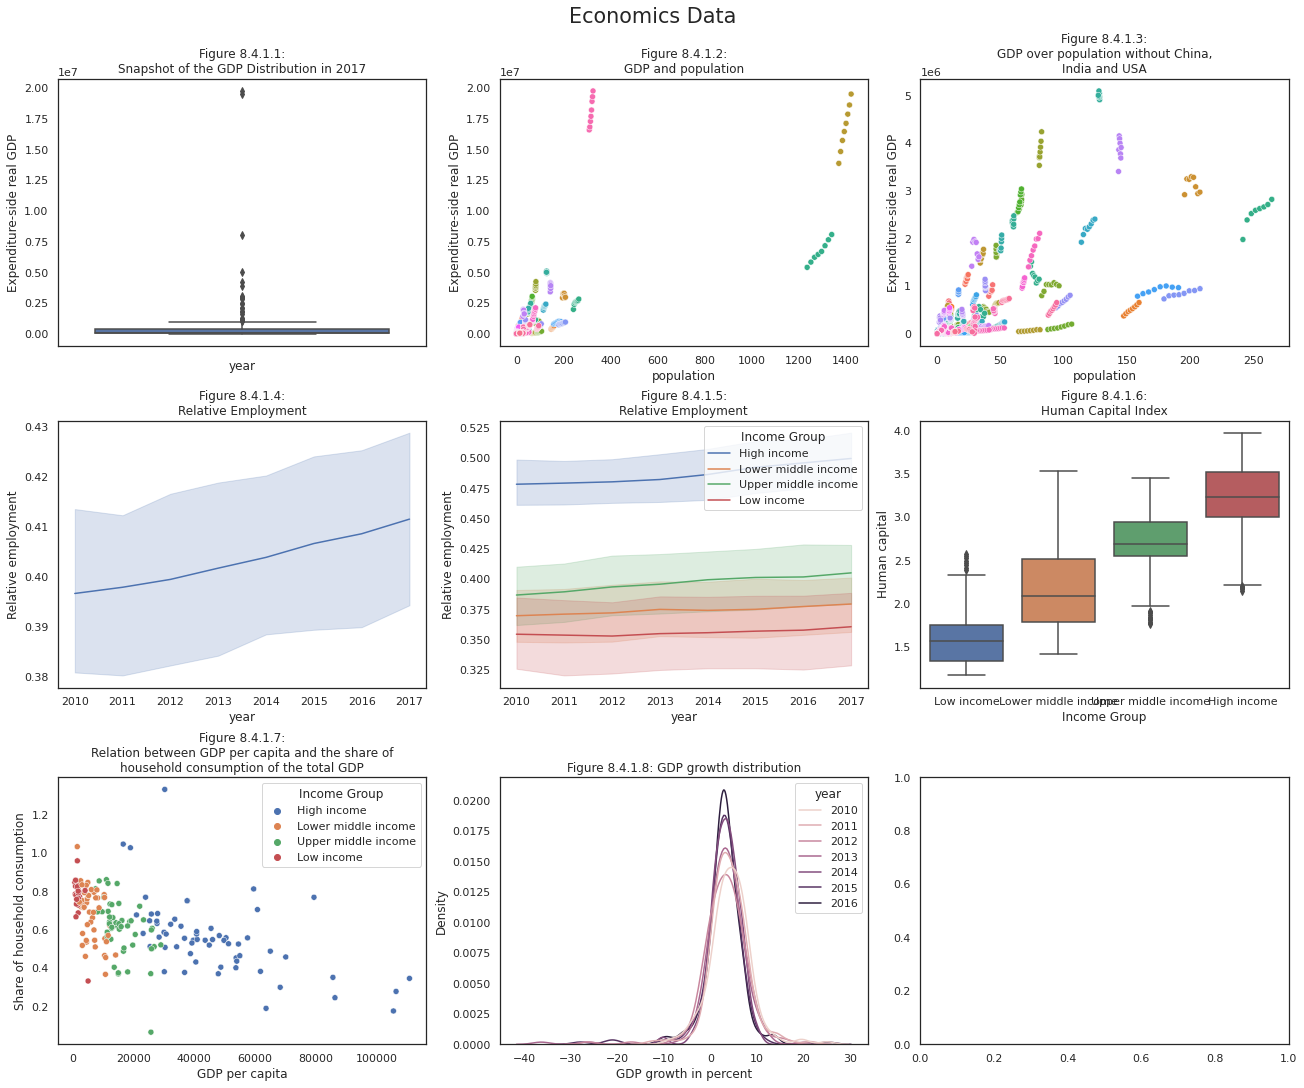

In [19]:
fig, axes = plt.subplots(3, 3, figsize=(18, 15), constrained_layout=True)

fig.suptitle('Economics Data', fontsize='xx-large')

sns.boxplot(ax=axes[0, 0], data=econ_data[econ_data.index.isin([2017], level=1)], y='rgdpe')
axes[0, 0].set(
    title='Figure 8.4.1.1:\nSnapshot of the GDP Distribution in 2017',
    ylabel='Expenditure-side real GDP',
    xlabel='year'
)

sns.scatterplot(ax=axes[0, 1], data=econ_data, x='pop', y='rgdpe', hue='country')
g = axes[0, 1].set(title='Figure 8.4.1.2:\nGDP and population', xlabel='population', ylabel='Expenditure-side real GDP')
axes[0,1].legend([],[], frameon=False)

sns.scatterplot(
    ax=axes[0, 2],
    data=econ_data[~econ_data.index.isin(['CHN', 'IND', 'USA'], level=0)],
    x='pop', y='rgdpe', hue='country'
)
axes[0, 2].set(
    title='Figure 8.4.1.3:\nGDP over population without China,\nIndia and USA',
    xlabel='population',
    ylabel='Expenditure-side real GDP'
)
axes[0, 2].legend([],[], frameon=False)

# Looking at the average employment: emp is in absolute numbers,
# so let's simply divide by population to have a relative figure
sns.lineplot(ax=axes[1, 0], data=econ_data, x='year', y='rel_emp')
axes[1, 0].set(title='Figure 8.4.1.4:\nRelative Employment', ylabel='Relative employment', xlabel='year')


# Looking at the relative employment in relation to income groups:
sns.lineplot(ax=axes[1, 1], data=econ_data[econ_data['rel_emp'] != 0], x='year', y='rel_emp', hue='Income Group')
axes[1, 1].set(title='Figure 8.4.1.5:\nRelative Employment', ylabel='Relative employment', xlabel='year')

sns.boxplot(ax=axes[1, 2], data=econ_data, y='hc', x='Income Group', order=income_order)
axes[1, 2].set(title='Figure 8.4.1.6:\nHuman Capital Index', ylabel='Human capital')


# csh_c & gdppc
ax = sns.scatterplot(ax=axes[2, 0], data=econ_data[econ_data.index.isin([2000, 2017], level=1)],
                     x='gdppc', y='csh_c', hue='Income Group') 
axes[2, 0].set(
    title='Figure 8.4.1.7:\nRelation between GDP per capita and the share of\nhousehold consumption of the total GDP',
    xlabel='GDP per capita',
    ylabel='Share of household consumption'
)

sns.kdeplot(
    ax=axes[2, 1],
    data=econ_data[econ_data.index.isin(range(2010, 2017), level=1)],
    x='gdp_g',
    hue='year',
    warn_singular=False
)
ax=axes[2, 1].set(title='Figure 8.4.1.8: GDP growth distribution', xlabel='GDP growth in percent')


#### Interesting Point for each Plots

**Figure 8.4.1.1:** The distribution of the real GDP shows many outliers at the top, which is as expected.

**Figure 8.4.1.2:** The distribution of the GDP per capita is interesting: There are not as many outliers as in the overall GDP distribution. However, the outliers are still larger than the 4x median.

**Figure 8.4.1.3:** As expected, the population plot is strongly dominated by China, India and the USA. If we remove the outliers it looks like the gpd has been increasing with an increasing population, at least for countries with a high population.

**Figure 8.4.1.4:** Looking at the underlying data it shows, that there are only up to 75 observations for data before 1960 and another discrepancy of available data for 1970. This does not conflict with the goal of figuring out how the gdp influences graduation rates.

**Figure 8.4.1.5:** Interesting to see, that the higher income group has a far higher relative employment than the lower & middle income groups, while it has been differently from the 1950s. It is also interesting to see that the low income group had a higher relative employment than the upper and lower middle income groups until the mid 2000s.

**Figure 8.4.1.6:** Unsurprisingly, the higher the Income Group of a country the higher the human capital index, although there are outliers especially in the upper middle and high income group with a low hc. Interesting.

**Figure 8.4.1.7:** The gdp growth has a normal distribution, with few outliers at top and bottom. Over the years, the distribution shifted to the right. Next we look at the human capital: We use it as a first estimate of the influence of economic data on the graduation rate.

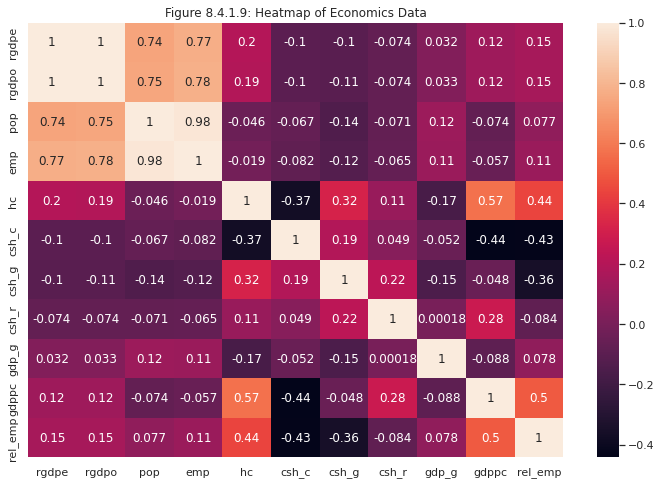

In [20]:
# Look at correlations to find out how the variables interact with a focus on relative attributes:
ax=sns.heatmap(
    econ_data[['rgdpe', 'rgdpo', 'pop', 'emp', 'hc', 'csh_c', 'csh_g', 'csh_r', 'gdp_g', 'gdppc', 'rel_emp']].corr(),
    annot=True
)

_ = ax.set(title='Figure 8.4.1.9: Heatmap of Economics Data')

**Figure 8.4.1.9:** The correlation heatmap shows that human capital (hc) shows a strong positive correlation with relative employment and the gdp per person. It also correaltes with rgdpe and rgdpo, while this could be due to outliers. We'll check this in a next step. Interestingly, human capital is negatively correlated with the share of household consumption (csh_c), while the share of government consumption (csh_g) shows a very low correlation, which is a little bit surprising.

#### 8.4.2 Data Exploration on the relationship between economics data and the primary school completion rate

In [21]:
# Merging data
data = pd.merge(econ_data, data_df.drop(columns=['Region', 'Income Group']), left_index=True, right_index=True)
data.sample(n=5, random_state=100).transpose()

country,DJI,LTU,LCA,SEN,KAZ
year,2011,2011,2013,2014,2010
rgdpe,2957.710449,77625.726562,2446.956787,40527.335938,326567.03125
rgdpo,3404.535889,72970.46875,1910.398193,42370.902344,331911.3125
pop,0.853674,3.083403,0.177513,14.174739,16.252279
emp,0.314647,1.279044,0.0739,5.129347,7.896011
hc,NaN,3.165248,NaN,1.524306,3.230118
ccon,2569.692627,64706.53125,2140.654785,38127.882812,207636.703125
cda,4570.370605,79749.585938,2664.400635,46787.609375,265764.65625
cgdpo,2971.544678,70435.679688,1934.290649,42010.765625,322726.25
cn,10801.675781,300871.96875,10406.408203,135238.015625,880149.4375


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1007 entries, ('ABW', 2010) to ('ZWE', 2017)
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rgdpe            1007 non-null   float64
 1   rgdpo            1007 non-null   float64
 2   pop              1007 non-null   float64
 3   emp              1007 non-null   float64
 4   hc               815 non-null    float64
 5   ccon             1007 non-null   float64
 6   cda              1007 non-null   float64
 7   cgdpo            1007 non-null   float64
 8   cn               1002 non-null   float64
 9   ck               774 non-null    float64
 10  ctfp             661 non-null    float64
 11  cwtfp            661 non-null    float64
 12  csh_c            1007 non-null   float64
 13  csh_g            1007 non-null   float64
 14  csh_r            1007 non-null   float64
 15  Region           1007 non-null   object 
 16  Income Group     1007 non-null   object

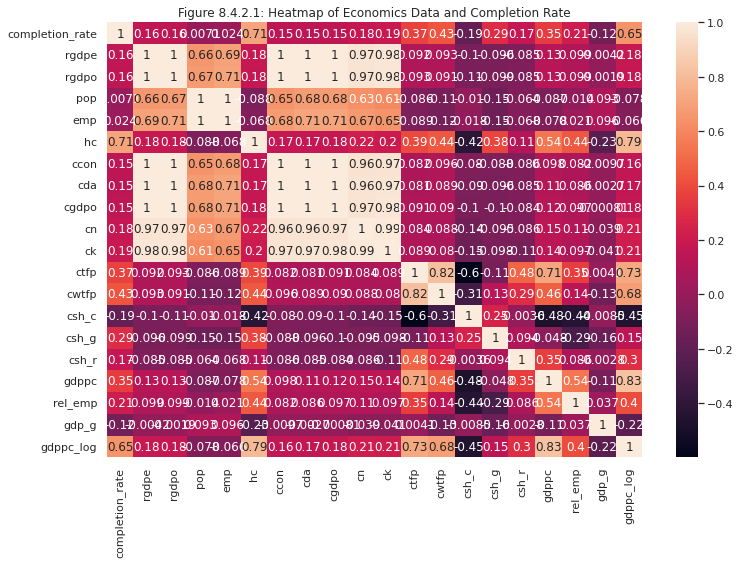

In [23]:
sns.set(style='white', rc={'figure.figsize':(12,8)})
ax = sns.heatmap(data[[
    'completion_rate', 'rgdpe', 'rgdpo', 'pop', 'emp',
    'hc', 'ccon', 'cda', 'cgdpo', 'cn', 'ck', 'ctfp',
    'cwtfp', 'csh_c', 'csh_g', 'csh_r', 'gdppc', 'rel_emp',
    'gdp_g', 'gdppc_log'
]].corr(), annot=True)

_ = ax.set(title='Figure 8.4.2.1: Heatmap of Economics Data and Completion Rate')

**Figure 8.4.2.1:** Looking especially at the completion rate, the direction of the correlations with the economic variables are largely similar with the previously discussed correlations with the human capital. We can see that the completion rate has a roughly equal correlation with the different gdp measurements (rgdpe, rgdpo, ccon, cda, cgdpo) which is as expected. The completion rate does barely correlate with the population or the absolute employment, but it shows a stronger correlation with the TFP level and the welfare relevant TFP levels (ctfp and cwtfp). There is a negative correlation with the share of household consumption (csh_c), which is, again, interesting. There is also a negative correlation with the annual gdp growth (gdp_g), which is also rather unexpected. There is a weaker correlation with the gdp per person and the relative employment. Further, there is a strong correlation between the completion rate and the log transformed gdp per person.

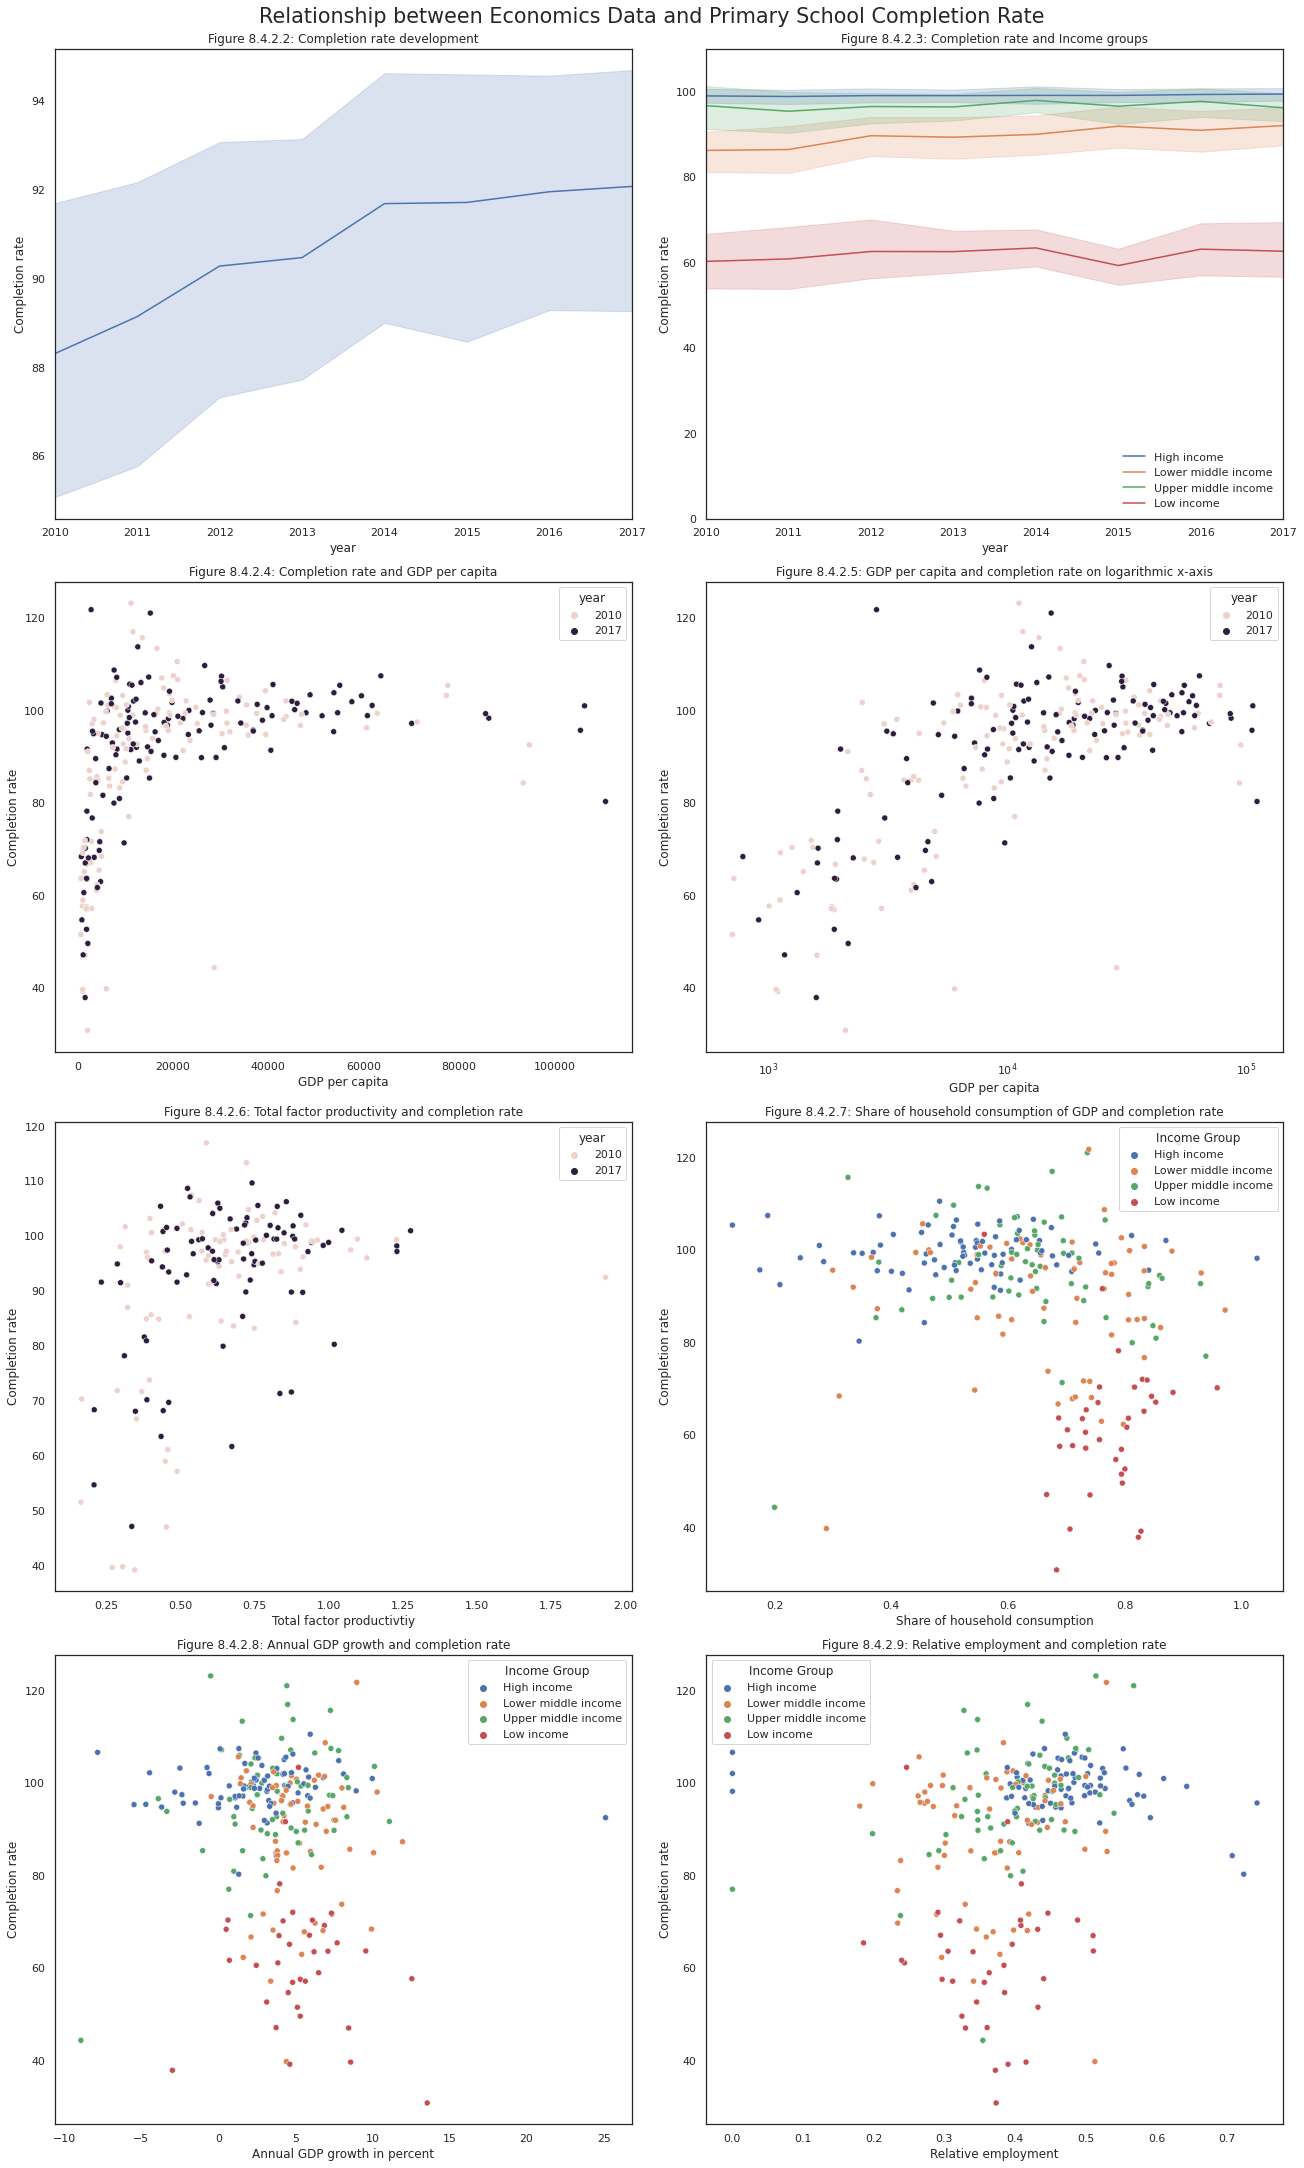

In [24]:
fig, axes = plt.subplots(4, 2, figsize=(18, 30), constrained_layout=True)

fig.suptitle('Relationship between Economics Data and Primary School Completion Rate', fontsize='xx-large')

ax = sns.lineplot(ax=axes[0, 0], data=data, x='year', y='completion_rate')
_ = axes[0, 0].set(
    title='Figure 8.4.2.2: Completion rate development',
    ylabel='Completion rate',
    xlabel='year',
    xlim=(2010, 2017)
)


ax = sns.lineplot(ax=axes[0, 1], data=data, x='year', y='completion_rate', hue='Income Group')
axes[0, 1].set(
    title='Figure 8.4.2.3: Completion rate and Income groups',
    ylabel='Completion rate',
    ylim=(0, 110),
    xlim=(2010, 2017)
)
axes[0, 1].legend(frameon=False, loc='lower right')


# 2017 completion rate and gdppc:
ax = sns.scatterplot(
    ax=axes[1, 0],
    data=data[data.index.isin([2010, 2017], level=1)],
    x='gdppc',
    y='completion_rate',
    hue='year'
)
axes[1, 0].set(title='Figure 8.4.2.4: Completion rate and GDP per capita',
               xlabel='GDP per capita',
               ylabel='Completion rate')

sns.scatterplot(
    ax=axes[1, 1],
    data=data[data.index.isin([2010, 2017], level=1)],
    x='gdppc', y='completion_rate', hue='year')
axes[1, 1].set(
    xscale="log",
    title='Figure 8.4.2.5: GDP per capita and completion rate on logarithmic x-axis',
    xlabel='GDP per capita',
    ylabel='Completion rate'
)


ax = sns.scatterplot(
    ax=axes[2, 0],
    data=data[data.index.isin([2010, 2017], level=1)],
    x='ctfp',
    y='completion_rate',
    hue ='year')
axes[2, 0].set(
    title='Figure 8.4.2.6: Total factor productivity and completion rate',
    xlabel='Total factor productivtiy',
    ylabel='Completion rate'
)


ax = sns.scatterplot(
    ax=axes[2, 1],
    data=data[data.index.isin([2010, 2017], level=1)],
    x='csh_c',
    y='completion_rate',
    hue='Income Group'
) 
axes[2, 1].set(
    title='Figure 8.4.2.7: Share of household consumption of GDP and completion rate',
    xlabel='Share of household consumption',
    ylabel='Completion rate'
)


# Gdp growth and completion rate
ax = sns.scatterplot(
    ax=axes[3, 0],
    data=data[data.index.isin([2010, 2017], level=1)],
    x='gdp_g',
    y='completion_rate',
    hue='Income Group'
)
axes[3, 0].set(
   title='Figure 8.4.2.8: Annual GDP growth and completion rate',
   xlabel='Annual GDP growth in percent',
   ylabel='Completion rate'
)

# Relative employment and completion rate
ax = sns.scatterplot(
    ax=axes[3, 1],
    data=data[data.index.isin([2010, 2017], level=1)],
    x='rel_emp', y='completion_rate',
    hue='Income Group')

ax=axes[3, 1].set(    
    title='Figure 8.4.2.9: Relative employment and completion rate',
    xlabel='Relative employment',
    ylabel='Completion rate'
)

#### Interesting Point for each Plots

**Figure 8.4.2.2:** The overall trend of the completion rate is positive.

**Figure 8.4.2.3:** The trend is pretty clear: The higher the income group, the higher the completion rate.

**Figure 8.4.2.4:** There is a logarithmic relationship between gdppc and completion rate, which is quite interesting. There are some outliers with a high gdppc, but a comparatively lower completion rate.

**Figure 8.4.2.5:** Similar to Figure 8.4.2.2, but use a logarithmic scale. We can see a linear relationship.

**Figure 8.4.2.6:** The relationship is not logarithmic but rather linear.

**Figure 8.4.2.7:** This graphs shows the negative correlation between the share of household consumption and the completion rate.

**Figure 8.4.2.8:** Also, not a 'clear' relationship here. One can see the slightly negative correlation.

**Figure 8.4.2.9:** We can see that there are some rough clusters of countries in one income group, but it is hard to make out a strong relationship between the relative employment and the completion rate.


### 8.5 Summary  & Important Variables

#### 8.5.1 Summary
We want to understand what influences the primary school graduation rate. Our hypothesis was, that the more income a country has, the higher its graduation rate as presumably its spending on education should be proportional to its income. As we already analyzed government expenditure, we focused on macroeconomic figures, that are somewhat independent from the government itself. We found that there is a relationship between the gdp per capita and the completion rate. We also found that the total factor productivity is correlated with the completion rate. The share of government consumption of the total gdp also influences the graduation rate, but not as much as expected. The answers make overall sense, but some aspects of them were surprising.

We didn't encounter many difficulties when analyzing the economic data. The main issue was to understand the domain specific terminology (e.g. total factor productivity) and how they influence the completion rate.

The key insight was that the completion rate has a strong relationship with the log GDP per capita.

We didn't find see biases in the economic data. We assumed that the Penn World Table data has been diligently and neutrally compiled. During the pre-filtering of attributes during data cleaning, we could have introduced some bias as we have made some ex ante assumptions about the attributes and their relationship to the completion rate. We could have missed some confounding variables, but as we only considered using 'hard' gdp or population data and derivatives, we do not expect that this decision has introduced a bias into the analysis.

During this exercise we could improve our knowledge of python and especially seaborn as a useful tools for visualizations. Also, as a team exericse, we could improve our communication and coordination skills.

#### 8.5.2 Important Variables
Concludingly, the data visualization and exploration shows that there is a strong relationship between the **log GDP per capita**,`log(gdppc)`, and **the completion rate**. There are some other relationships, but the log GDP per capita is by far the clearest.

## 9. Government Spending Data

We chose a base data set from the Education Statistics data from World Bank. We also downloaded the gdp and population data from World Development data from World Bank as well, to combine with the base data set.

We chose this data set because after researching the internet, this data set covered the most countries, and had the most historic data. Also, it had the least missing values of the time span we wanted, which is something that we ran into a lot with country data in general. Another plus was that the World Bank had an online Query tool that helps us visualize, organize and download data.

### 9.1 Data Definition and Initial Gathering

We got the data in this section from [the World Bank Open Data](https://datacatalog.worldbank.org/search/dataset/0037712).

- **gov_exp_level (US dollars millions)** (Government expenditure on level of education, constant US dollars (millions))
    - *Total general (local, regional and central) government expenditure on level of education (current, capital, and transfers) in millions US dollars in constant value (taking into account inflation). It includes expenditure funded by transfers from international sources to government. Total government expenditure for a given level of education (e.g. primary, secondary, or all levels combined) in national currency is converted to US dollars, and where it is expressed in constant value, uses a GDP deflator to account for inflation. The constant prices base year is normally three years before the year of the data release. For example, in the July 2017 data release, constant US dollars values are expressed in 2014 prices. Limitations: In some instances data on total government expenditure on education refers only to the Ministry of Education, excluding other ministries which may also spend a part of their budget on educational activities.*
- **gov_exp_primary_per_person (US dollars)** (Government expenditure on primary education per person in country)
    - *gov_exp_level (US dollars millions) / population * 1000000*
- **gov_exp_level (% of GDP)** (Government expenditure on level of education, constant US dollars (millions))
    - *Total general (local, regional and central) government expenditure on level of education (current, capital, and transfers), expressed as a percentage of GDP. It includes expenditure funded by transfers from international sources to government. Divide total government expenditure for a given level of education (ex. primary, secondary, or all levels combined) by the GDP, and multiply by 100. A higher percentage of GDP spent on education shows a higher government priority for education, but also a higher capacity of the government to raise revenues for public spending, in relation to the size of the country's economy. When interpreting this indicator however, one should keep in mind in some countries, the private sector and/or households may fund a higher proportion of total funding for education, thus making government expenditure appear lower than in other countries. Limitations: In some instances data on total public expenditure on education refers only to the Ministry of Education, excluding other ministries which may also spend a part of their budget on educational activities.*
- **all_staff_compensation_primary** (All staff compensation as % of total expenditure in primary public institutions)
    - *All staff (teacher and non-teachers) compensation expressed as a percentage of direct expenditure in public educational institutions (instructional and non-instructional) on the primary level of education. Financial aid to students and other transfers are excluded from direct expenditure. Staff compensation includes salaries, contributions by employers for staff retirement programmes, and other allowances and benefits.*
- **oecd** (Organisation for Economic Co-operation and Development)
    - *The Organisation for Economic Co-operation and Development is an intergovernmental economic organisation with 38 member countries, founded in 1961 to stimulate economic progress and world trade. This column represents whether the country is in the organization (1) or not (0).*
- **gdp**
    - *GDP at purchaser's prices is the sum of gross value added by all resident producers in the economy plus any product taxes and minus any subsidies not included in the value of the products. It is calculated without making deductions for depreciation of fabricated assets or for depletion and degradation of natural resources. Data are in current U.S. dollars. Dollar figures for GDP are converted from domestic currencies using single year official exchange rates. For a few countries where the official exchange rate does not reflect the rate effectively applied to actual foreign exchange transactions, an alternative conversion factor is used.* 
- **population**
    - *Total population is based on the de facto definition of population, which counts all residents regardless of legal status or citizenship. The values shown are midyear estimates.* 

In [25]:
# Utility Function
def count_missing(frame):
    return (frame.shape[0] * frame.shape[1]) - frame.count().sum()

def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

warnings.filterwarnings('ignore')

### 9.2 Loading the data

In [26]:
financing_df = pd.read_csv('data/education_financing/base.csv')
gdp = pd.read_csv('data/education_financing/gdp.csv')
pop = pd.read_csv('data/education_financing/population.csv')

financing_df.sample(n=5, random_state=10).transpose()

,1426,442,2615,579,883
Time,2015,2011,2019,2012,2013
Time Code,YR2015,YR2011,YR2019,YR2012,YR2013
Country Name,Germany,Netherlands,Russian Federation,Chile,Finland
Country Code,DEU,NLD,RUS,CHL,FIN
Government expenditure on pre-primary education as % of GDP (%) [UIS.XGDP.0.FSGOV],0.4588,0.37988,..,0.6367,0.76615
Government expenditure on primary education as % of GDP (%) [UIS.XGDP.1.FSGOV],0.62531,..,..,1.45673,1.3262
Government expenditure on secondary education as % of GDP (%) [UIS.XGDP.23.FSGOV],2.02367,..,..,1.48915,2.69145
Government expenditure on tertiary education as % of GDP (%) [UIS.XGDP.56.FSGOV],1.25463,..,..,0.95913,1.99769
"Government expenditure on pre-primary education, US$ (millions) [UIS.X.US.02.FSGOV]",15418.24265,3434.48003,..,1700.75809,2078.44509
"Government expenditure on primary education, US$ (millions) [UIS.X.US.1.FSGOV]",21013.86938,..,..,3891.24497,3597.77862


### 9.3 Data Cleaning

#### 9.3.1 Overview
We cleaned the data using python and all of its helpful libraries. We imported the data sets, renamed the columns, drop the columns that had more than 90% of the data missing. We then also dropped the countries that had the most data missing, cleaned the missing values, maked sure that all the data is in the proper format, set data sets indexes the same in all different data sets, merged them into one.

#### 9.3.2 Missing Value
We researched quite a lot about missing data, especially in this context. In the end we concluded, that we would drop the columns and countries that had too many missing values, and then do hot-deck mean imputation. For a country that would have some value missing in a column, we would check if that country has the column data for other years, and if it does we would impute the other years mean into the missing values spot. Then, all the countries that were still left with the missing values, we did the following. We created 10 categories for countries, and we organized them by their gdp. If a country was missing a value in a certain columns, we would get the mean of that column from the other countries in its gdp category.

First, we dropped the columns and years that had most of the data missing because it didn't make sense for us to fill ourselves 60%-70% of the data, as the data missing was huge. The data missing was nowhere to be found on the internet, because most of it wasn't recorded in the first place, or lost due to many different variables. We then did hot-deck imputation because the countries that had data from other years in the columns that had missing values, were always very similar. Imputing the mean would be almost as good as having the real data, as the fluctuations were tiny year to year. Then the hot deck imputation from a countries gdp category was a decent solution, as the countries usually spend similar on education.

In [27]:
# removing the rows that did not had country names or code, dropping unnecessary columns
financing_df = financing_df.replace('..', float("NaN"))

financing_df.drop([
    'Time Code',
    'Teaching staff compensation as a percentage '
    + 'of total expenditure in primary public institutions'
    + ' (%) [UIS.XSPENDP.1.FDPUB.FNTS]'
], axis=1, inplace=True)

financing_df = financing_df[financing_df['Country Name'].notna()]
financing_df = financing_df[financing_df['Country Code'].notna()]

financing_df['Time'] = financing_df['Time'].apply(lambda x:int(x))

# renaming the columns 
financing_df.columns = ['Year','Entity', 'Code',
       'gov_exp_pre_primary (% of GDP)',
       'gov_exp_primary (% of GDP)',
       'gov_exp_secondary (% of GDP)',
       'gov_exp_tertiary (% of GDP)',
       'gov_exp_pre_primary (US $ millions)',
       'gov_exp_primary (US $ millions)',
       'gov_exp_secondary (US $ millions)',
       'gov_exp_tertiary (US $ millions)',
       'gov_exp_all_levels (US $ millions)',
       'all_staff_compensation_primary',
       'capital_exp_primary']

financing_df.sort_values(by=['Year'], inplace=True)
financing_df.set_index(['Entity', 'Code', 'Year'], inplace=True)

# keeping the country that had most of the data available
countries_keep = financing_df.groupby('Entity').apply(count_missing).sort_values().index.values[:120]

financing_df.reset_index(inplace=True)
financing_df = financing_df.loc[financing_df['Entity'].isin(countries_keep)]
financing_df.set_index(['Entity', 'Code', 'Year'], inplace=True)

# keeping the rows that had most of the data available
perc = 60.0
min_count =  int(((100-perc)/100)*financing_df.shape[1] + 1)
financing_df = financing_df.dropna(axis=0, thresh=min_count)

# creating a categorical variable to add information whether the country is in the oecd organization
oecd = [
    "Austria", "Australia", "Belgium",
    "Canada", "Chile", "Colombia",
    "Costa Rica", "Czech Republic",
    "Denmark", "Estonia", "Finland",
    "France", "Germany", "Greece",
    "Hungary", "Iceland", "Ireland",
    "Israel", "Italy", "Japan", "South Korea",
    "Latvia", "Lithuania", "Luxembourg",
    "Mexico", "Netherlands", "New Zealand",
    "Norway", "Poland", "Portugal", "Slovakia",
    "Slovenia", "Spain", "Sweden", "Switzerland",
    "Turkey", "United Kingdom", "United States"
]

financing_df.reset_index(inplace=True)
financing_df['oecd'] = financing_df['Entity'].apply(lambda x: 1 if x in oecd else 0)
financing_df.set_index(['Entity', 'Code', 'Year'], inplace=True)

# cleaning the gdp data set
gdp.drop(['Series Name', 'Series Code'], axis=1, inplace=True)
gdp.columns = ['Entity', 'Code', '2010', '2011',
       '2012', '2013', '2014', '2015',
       '2016', '2017', '2018', '2019',
       '2020']

gdp = gdp.melt(id_vars=["Entity", "Code"],
    var_name="Year", 
        value_name="Gdp (USD)")
gdp['Year'] = gdp['Year'].apply(lambda x:int(x))
gdp.set_index(['Entity', 'Code', 'Year'], inplace=True)
gdp.sort_values(by=['Entity', 'Year'], inplace=True)
gdp.replace('..', float("NaN"), inplace=True)
gdp.dropna(inplace=True)

# merging the gdp and base data set
financing_df = financing_df.join(gdp)

financing_df = financing_df.astype(float)
financing_df['oecd'] = financing_df['oecd'].apply(lambda x: int(x))

financing_df.sort_values(by=['Entity'], inplace=True)

# clean the population data set and merge with the base data set
pop.drop(['Time Code'], axis=1, inplace=True)
pop.columns = ['Year', 'Entity', 'Code',
       'population']
pop = pop[['Entity', 'Code', 'Year', 'population']]
pop.dropna(inplace=True)
pop['Year'] = pop['Year'].apply(lambda x: int(x))
pop.set_index(['Entity', 'Code', 'Year'], inplace=True)
financing_df = financing_df.join(pop)

# There was one gdp value missing for South Sudan 2016 so it was added manually. 
# Data is from google. The rest of the data also match the google data.

financing_df = financing_df.sort_index()
financing_df['Gdp (USD)'].loc['South Sudan', 'SSD', 2016] = 52000000000.000

In the next code block, we will do data imputation. Thus, we will split the test data here to avoid data leakage.

In [28]:
test_financing_df = financing_df.loc[(slice(None), slice(None), slice(2018, 2020)),:]
financing_df = financing_df.loc[(slice(None), slice(None), slice(2017)),:]

In [29]:
# filling the missing values with mean values from different years data (same country)

countries = financing_df.reset_index()['Entity'].unique()

na_countries = list()
mean_value_impute = {}
for column in financing_df.columns[:-2]:
    for country in countries:
        if((financing_df.loc[country][column].isna().sum() > 0) \
           and (financing_df.loc[country].shape[0] != financing_df.loc[country][column].isna().sum())):
            na_countries.append(country)
            impute_value = np.nanmean(financing_df.loc[country][column].values)
            if not country in mean_value_impute:
                mean_value_impute[country] = {}
            mean_value_impute[country][column] = impute_value
            financing_df[column].loc[country].fillna(impute_value, inplace=True)

# cleaning the missing values that the country had no data for that specific column, using hot deck imputation placing the
# mean value from similar gdp category countries
countries_by_gdp = financing_df.groupby('Entity').mean().sort_values(by=['Gdp (USD)']).reset_index()
countries_by_gdp_names = countries_by_gdp['Entity'].values

countries_split = list(split(range(111), 10))

for column in financing_df.columns[:-2]:
    for country in countries_by_gdp_names:
        for i in countries_split:
            if(country in countries_by_gdp_names[i]):
                category = i
        value = np.nanmean(financing_df.loc[countries_by_gdp_names[category]][column].values)
        if country not in mean_value_impute:
            mean_value_impute[country] = {}
        financing_df.loc[country][column].fillna(value, inplace=True)

Here we impute the data for the test set using information from the training set.

In [30]:
for column in test_financing_df.columns[:-2]:
    for country in countries:
        if country in test_financing_df.index:
            if((test_financing_df.loc[country][column].isna().sum() > 0) \
               and (test_financing_df.loc[country].shape[0] != test_financing_df.loc[country][column].isna().sum())):
                impute_value = np.nanmean(financing_df.loc[country][column].values)
                test_financing_df[column].loc[country].fillna(impute_value, inplace=True)
for column in test_financing_df.columns[:-2]:
    for country in countries_by_gdp_names:
        if country in test_financing_df.index:
            for i in countries_split:
                if(country in countries_by_gdp_names[i]):
                    category = i
            value = np.nanmean(financing_df.loc[countries_by_gdp_names[category]][column].values)
            test_financing_df.loc[country][column].fillna(value, inplace=True)

We continue format the data below. Also, we do the same with the test data.

In [31]:
# creating the gov_exp_primary column based on population and gov_exp_primariy (US $ millions)
financing_df["population"] = pd.to_numeric(financing_df["population"], downcast="float")
financing_df['gov_exp_primary_per_person (US dollars)'] = (
    financing_df['gov_exp_primary (US $ millions)'] / financing_df['population']
) * 1000000

# final renaming and index setting
financing_df.reset_index(inplace=True)
if 'Entity' in financing_df.columns:
    financing_df.drop(['Entity'], axis=1, inplace=True)
financing_df = financing_df.rename(columns = {'Code':'country', 'Year': 'year', 'Gdp (USD)':'gdp'})
financing_df.set_index(['country', 'year'], inplace=True)


# creating the gov_exp_primary column based on population and gov_exp_primariy (US $ millions)
test_financing_df["population"] = pd.to_numeric(test_financing_df["population"], downcast="float")
test_financing_df['gov_exp_primary_per_person (US dollars)'] = (
    test_financing_df['gov_exp_primary (US $ millions)'] / test_financing_df['population']
) * 1000000

# final renaming and index setting
test_financing_df.reset_index(inplace=True)
if 'Entity' in test_financing_df.columns:
    test_financing_df.drop(['Entity'], axis=1, inplace=True)
test_financing_df = test_financing_df.rename(columns = {'Code':'country', 'Year': 'year', 'Gdp (USD)':'gdp'})
test_financing_df.set_index(['country', 'year'], inplace=True)

In [32]:
financing_df.sample(n=5, random_state=10).transpose()

country,MDA,JAM,MWI,DMA,KEN
year,2012,2016,2013,2012,2011
gov_exp_pre_primary (% of GDP),1.530930e+00,2.000000e-01,1.580000e-03,6.141000e-02,1.277000e-02
gov_exp_primary (% of GDP),1.275680e+00,1.906730e+00,1.989680e+00,1.551130e+00,2.059540e+00
gov_exp_secondary (% of GDP),2.435340e+00,2.069890e+00,1.323440e+00,5.056270e+00,2.270340e+00
gov_exp_tertiary (% of GDP),1.226500e+00,9.688900e-01,1.535800e+00,3.020900e-01,6.818100e-01
gov_exp_pre_primary (US $ millions),1.333310e+02,2.837608e+01,9.519000e-02,3.076700e-01,5.108970e+00
gov_exp_primary (US $ millions),1.111013e+02,2.705211e+02,1.199479e+02,7.771550e+00,8.238165e+02
gov_exp_secondary (US $ millions),2.120974e+02,2.936697e+02,7.978370e+01,2.533323e+01,9.081375e+02
gov_exp_tertiary (US $ millions),1.068181e+02,1.374626e+02,9.258539e+01,1.571470e+00,2.727266e+02
gov_exp_all_levels (US $ millions),6.081952e+02,7.540869e+02,3.265129e+02,1.773169e+01,2.134121e+03


### 9.4 Data Exploration

#### 9.4.1 Data Exploration on the Government Spending Dataset

Summary statistics of the education financing dataset.

In [33]:
financing_df.describe(percentiles=[]).transpose()

,count,mean,std,min,50%,max
gov_exp_pre_primary (% of GDP),741.0,3.377400e-01,3.182217e-01,0.000000e+00,2.962800e-01,1.530930e+00
gov_exp_primary (% of GDP),741.0,1.446961e+00,6.444360e-01,1.943000e-02,1.436100e+00,7.330910e+00
gov_exp_secondary (% of GDP),741.0,1.558085e+00,6.701717e-01,1.091300e-01,1.585350e+00,5.056270e+00
gov_exp_tertiary (% of GDP),741.0,9.405903e-01,5.187189e-01,4.540000e-03,9.037000e-01,2.736040e+00
gov_exp_pre_primary (US $ millions),741.0,1.577711e+03,5.254282e+03,0.000000e+00,1.240813e+02,6.166253e+04
gov_exp_primary (US $ millions),741.0,6.151213e+03,2.387566e+04,7.301590e+00,6.236715e+02,2.936362e+05
gov_exp_secondary (US $ millions),741.0,8.104152e+03,2.803762e+04,2.957430e+00,6.436579e+02,3.256256e+05
gov_exp_tertiary (US $ millions),741.0,5.263267e+03,2.070628e+04,4.690100e-01,3.613316e+02,2.721613e+05
gov_exp_all_levels (US $ millions),741.0,2.137786e+04,7.422951e+04,1.308125e+01,1.962144e+03,8.328206e+05
all_staff_compensation_primary,741.0,7.424336e+01,1.360788e+01,0.000000e+00,7.509977e+01,1.000000e+02


[Text(0.5, 1.0, 'Figure 9.4.4: Scatter plot gov_exp_primary vs gdp')]

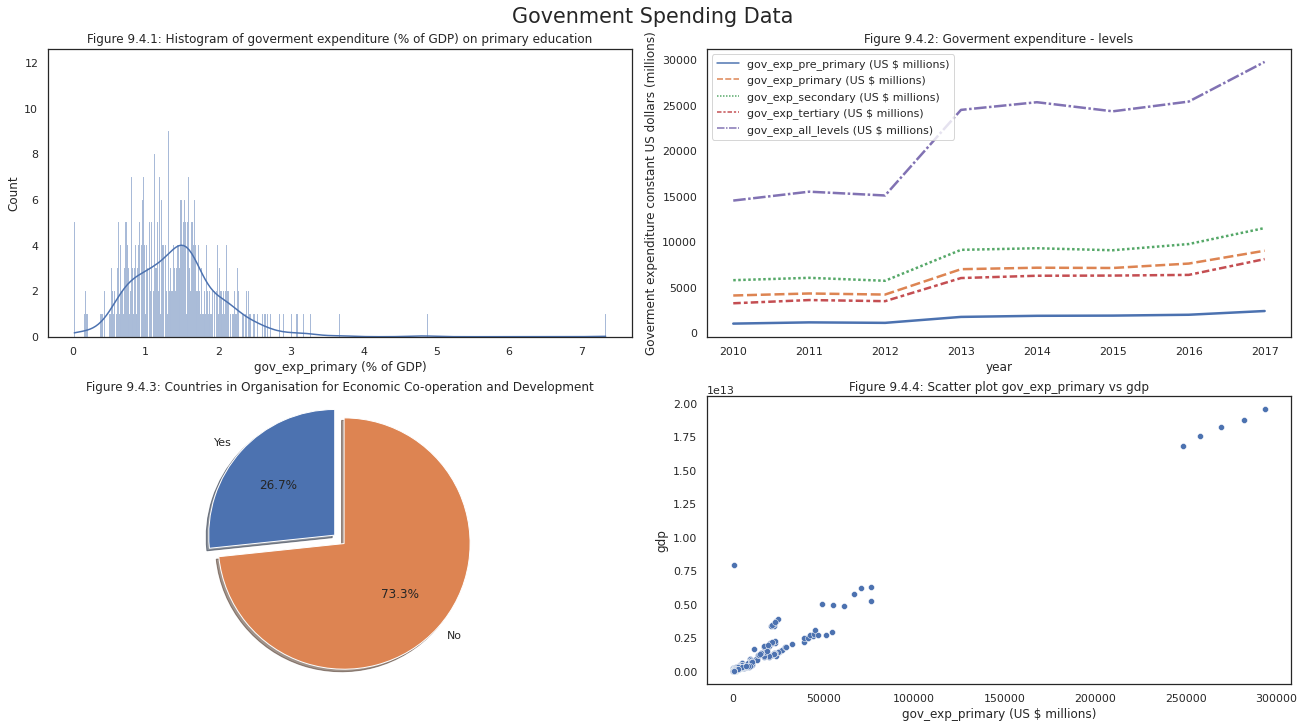

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10), constrained_layout=True)

fig.suptitle('Govenment Spending Data', fontsize='xx-large')
sns.histplot(ax=axes[0, 0], data=financing_df['gov_exp_primary (% of GDP)'], kde=True, bins=1000)
axes[0, 0].set(title="Figure 9.4.1: Histogram of goverment expenditure (% of GDP) on primary education")

sns.lineplot(
    ax=axes[0, 1],
    data=financing_df.reset_index().groupby('year').mean().iloc[:, 4:9],
    linewidth = 2.5
)
axes[0, 1].set(title='Figure 9.4.2: Goverment expenditure - levels',
               ylabel="Goverment expenditure constant US dollars (millions)")


yes = ((financing_df.reset_index().groupby('country').mean()['oecd'].sum()
        / len(financing_df.reset_index()['country'].unique())) * 100)
no = 100 - yes
labels = 'Yes', 'No'
sizes = [yes, no]
explode = (0.1, 0)
axes[1, 0].pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
axes[1, 0].axis('equal')
axes[1, 0].set(title="Figure 9.4.3: Countries in Organisation for Economic Co-operation and Development")

#scatter plot gov_exp_primary/gdp
sns.scatterplot(
    ax=axes[1, 1],
    data=financing_df,
    x='gov_exp_primary (US $ millions)',
    y='gdp'
)
axes[1, 1].set(title="Figure 9.4.4: Scatter plot gov_exp_primary vs gdp")

#### Interesting Point for each Plots

**Figure 9.4.1:** We see from the histogram that the goverment expenditure on primary education follows a normal distributio which is expected. There are some countries that seem like outliers, those are just countries like Norway, New Zealand, who spend a lot on education.

**Figure 9.4.2:** We see that the primary expenditure is the 2nd highest among the levels of education after secondary.

**Figure 9.4.3:** A pie chart demonstrating how many of our countries are included in Organisation for Economic Co-operation and Development which is an organisation that stimulates economic progress and world trade. The countries included are the wealthiest and most developed countries in general, so this chart is a good indicator of what countries our data consist off.

**Figure 9.4.4:** Visualization of the expected linear relationship between gdp and goverment expenditure on primary education. At the far top right we see some points that look like outliers. Those are actually USA, Japan, UK, Germany, Brazil. The wealthies countries in our data set by far, and it is not unsual that they invest a lot in education.

#### 9.4.2 Data exploration on the relationship between government spending data and the primary school completion rate

In [35]:
# import the base data set, set indexes to match, take the important variable out,
# merge with financing_education df, drop nas
merged_financing_df = pd.merge(financing_df, data_df, left_index=True, right_index=True)
merged_financing_df.dropna(inplace=True)

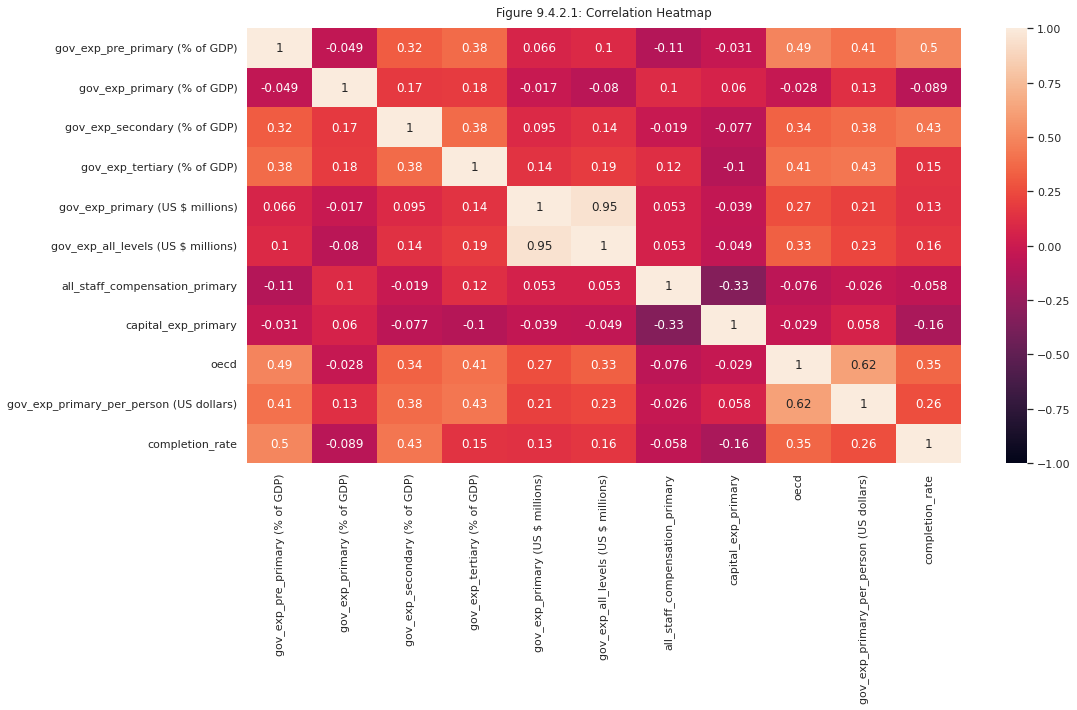

In [36]:
plt.figure(figsize=(16, 8))
heatmap = sns.heatmap(merged_financing_df.drop([
    'population',
    'gdp',
    'gov_exp_pre_primary (US $ millions)',
    'gov_exp_secondary (US $ millions)',
    'gov_exp_tertiary (US $ millions)'
], axis=1).corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Figure 9.4.2.1: Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

**Figure 9.4.2.1:** From the correlation heatmap, we see that the correlation is moderately correlated with `gov_exp_pre_primary`, `gov_exp_secondary`, and `oecd`. The odd thing is that it is slightly negatively correlated with `gov_exp_primary`

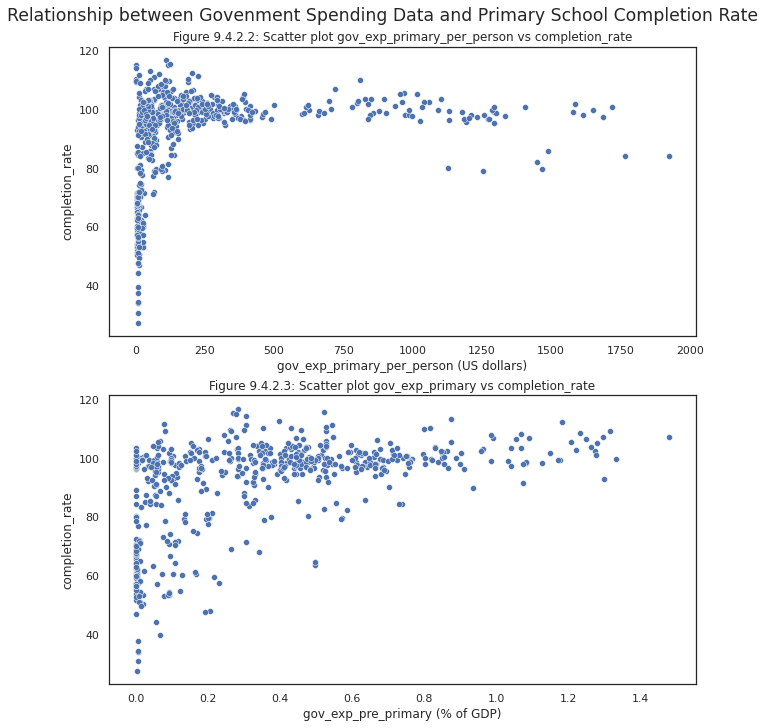

In [37]:
fig, axes = plt.subplots(2, 1, figsize=(9, 10), constrained_layout=True)
fig.suptitle('Relationship between Govenment Spending Data and Primary School Completion Rate', fontsize='x-large')

#scatter plot gov_exp_primary_per_person (US dollars)/completion_rate
sns.scatterplot(
    ax=axes[0],
    data=merged_financing_df,
    x='gov_exp_primary_per_person (US dollars)',
    y='completion_rate'  
)
axes[0].set(
    title="Figure 9.4.2.2: Scatter plot gov_exp_primary_per_person vs completion_rate"
)
#scatter plot gov_exp_primary/completion_rate
sns.scatterplot(
    ax=axes[1],
    data=merged_financing_df,
    x='gov_exp_pre_primary (% of GDP)',
    y='completion_rate'
)
_ = axes[1].set(title="Figure 9.4.2.3: Scatter plot gov_exp_primary vs completion_rate")

**Figure 9.4.2.2:** We see that as long as the goverment invests more than 100 US$ per person for primary education, the completion rate will be 80% or more.

**Figure 9.4.2.3:** The visualization of the high correlation between gov_exp_pre_primary and completion rate looks interesting. We presume the goverment expenditure on pre-primary education prepares the kids to be good in primary school, and that has lasting effects. But the correlation is also appearant between exp on secondary aducation and completion_rate.

### 9.5 Summary  & Important Variables

#### 9.5.1 Summary
We can see that it does influence the completion rate. However, we were suprised that the expenditure on certain level of education doesn't necessery influence that education levels completion rate.

This is a complicated multivariate problem, that will be better understood when we combine the data sets together, and many of these small influences come together.

#### 9.5.2 Important Variables
From the data exploration, `gov_exp_pre_primary (% pf GDP)`, `gov_exp_secondary (% pf GDP)` and `oecd` are variable that seem to have relationship with the `completion_rate`.

## 10. Predictive Model

Because of a mistake of our team process, the health data contain only information upto 2015 but not 2019 as we expected initially. We realize this at near the end of the project, thus we cannot change other part of the project accordingly. In conclusion, we decided to drop the health data from the prediction model.

### 10.1 Machine Learning Algorithm Used

We try using the most general model like Random Forest to see if it is possible to get any good prediction from the data.

In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [39]:
variables = ['gdppc', 'gov_exp_pre_primary (% of GDP)', 'gov_exp_secondary (% of GDP)', 'oecd']

### 10.2 Training Data

In [40]:
train_df = merged_financing_df.drop(columns=['Region', 'Income Group']).merge(econ_data, left_index=True, right_index=True)
y_train = train_df['completion_rate']
X_train = train_df.drop(columns=['completion_rate'])[variables]
X_train['log_gdppc'] = np.log(X_train['gdppc'])
X_train = X_train.drop(columns=['gdppc'])

In [41]:
X_train.shape

(555, 4)

### 10.3 Training

For the data preprocessing for the Machine Learning Model, we use One-Hot Encoding to encode variable like `Region` and `Income Group`. We also use `Pipeline` to make it easier and consistent for both training and testing data preprocessing.

In [42]:
pipe = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False)),
    ('algorithm', RandomForestRegressor(random_state=100))
])
grid = pipe.fit(X_train, y_train)

In [43]:
train_predict = pipe.predict(X_train)
print('Training RMSE', np.sqrt(np.mean((y_train - train_predict)**2)))

Training RMSE 6.397857960064912


### 10.4 Testing

#### 10.4.1 Data Preprocessing For Testing Set

In [44]:
test_base_df = test_data_df.set_index(['country', 'year'])

In [45]:
test_df = test_base_df.drop(columns=['Region', 'Income Group']).merge(test_financing_df, left_index=True, right_index=True)\
    .merge(test_econ_data, left_index=True, right_index=True)
y_test = test_df['completion_rate']
X_test = test_df.drop(columns=['completion_rate'])[variables]
X_test['log_gdppc'] = np.log(X_test['gdppc'])
X_test = X_test.drop(columns=['gdppc'])

In [46]:
X_test.shape

(48, 4)

#### 10.4.2 Testing Result

In [47]:
test_predict = pipe.predict(X_test)
print('Testing RMSE', np.sqrt(np.mean((y_test - test_predict)**2)))

Testing RMSE 15.872133723936042


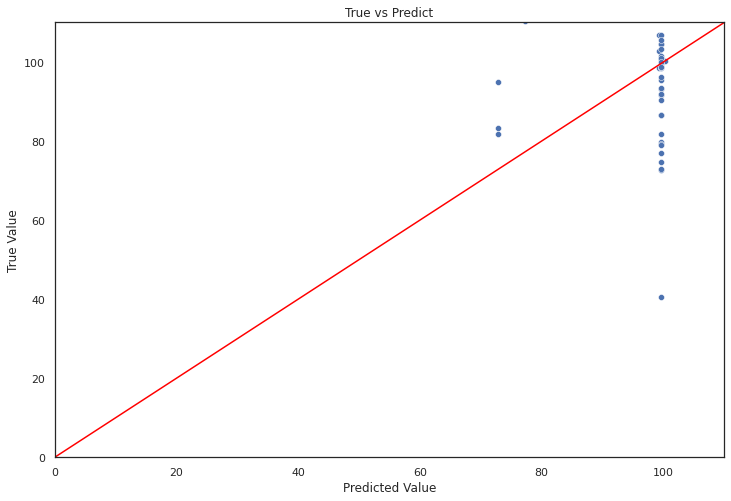

In [48]:
ax = sns.scatterplot(x=test_predict, y=y_test)
sns.lineplot(x=[0, 200], y=[0, 200], color='red')
_ = ax.set(title='True vs Predict', xlabel='Predicted Value', ylabel='True Value', xlim=[0, 110], ylim=[0, 110])


### 10.5 Summary

As expected, because of the data we have contain a lot of missing value. After, we combined all of the dataset together the resulting data were even dropped away in the process. Thus, we might not have enough data to create a good model. Moreover, the completion rate contains a lot of outliers which make it hard to predict.

## 11. Summary & Discussion

### Conclusion & Key Insight
- From our exploratory data analysis, our report identifies the following variables as variables that could influence the primary school completion rate; GDP per capita, Government Expense on Primary School (%GDP), Government Expense on Secondary School (%GDP),  OECD (boolean), child and maternal mortality, life expectancy.
- However, we only be able to identify them from correlate trends. We know that correlation might not imply causation. The trend may be influenced by other hidden variables.
- We have failed in an attempt to create a prediction model for the primary school completion rate using our approach. 

### Potential Bias
- The potential biases are that the low income countries don't really have a lot of data recorded, so our final data set would consist of mostly middle-high income countries. But we were surprised, when we merged the final data and realized it's not the case. Something else, cant think of.
- Also, we focus mainly on linear relationship. Thus, we might miss variable that contribute on the target variable in a more complex way.

### Difficulty
- Scope our question. Originally, we start by a very board list of question, then need to scope them down to be able to answer our question in more detail. But the change of plan and cost some time.
- Gathering country data that’s consistent and accurate. Recent data are also hard to find.
- Data Format: The world bank data took more time to clean than expected
- Missing values: Especially smaller or lower income countries have many missing values, which might bias the analysis 
- Integration of data from multiple sources which have a different missing value, format and time frame.

### Data Science tools and techniques

We got experience in using Python and it's libraries for a real world data science project, where the most of the workload is in data gathering and cleaning. We also got to work a lot more with **Seaborn**, a data visualisation library. It enables us to create a more complex visualisation that could identify underlying trends. Also, we implemented hot-deck mean imputation, a technique that isn't widely researched and supported like the others but worked well in our case.


## 12. Team Management

This project are made by Group 41. The work are divided into 4 part.

- András Bonifác Kónya (ID:01502933) did the health data section.
- Branimir Raguž (ID:12123474) did the government spending section.
- Paul Georg Direktor (ID:12117574) did the economics section.
- Thummanoon Kunanuntakij (ID:12122522) managed the overall of the project, put together the report file and make the prediction model.
